In [1]:
import numpy as np
import math
from collections import Counter

In [2]:
from functools import reduce

In [3]:
def calc_shannon_ent(data_set):
    num_entries = len(data_set)
    label_counts = Counter(feat_vec[-1] for feat_vec in data_set)
    probs = (label_counts[key]/num_entries for key in label_counts)
    shannon_ent = reduce(lambda s, prob: s-prob*math.log(prob, 2), probs, 0.0)
    return shannon_ent

In [4]:
help(reduce) 

Help on built-in function reduce in module _functools:

reduce(...)
    reduce(function, sequence[, initial]) -> value
    
    Apply a function of two arguments cumulatively to the items of a sequence,
    from left to right, so as to reduce the sequence to a single value.
    For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates
    ((((1+2)+3)+4)+5).  If initial is present, it is placed before the items
    of the sequence in the calculation, and serves as a default when the
    sequence is empty.



In [5]:
def create_data_set():
    data_set = [[1, 1, "yes"],
               [1, 1, "yes"],
               [1, 0, "no"],
               [0, 1, "no"],
               [0, 1, "no"]]
    labels = ["no surfacing", "flippers"]
    return data_set, labels

In [6]:
my_dat, labels = create_data_set()

In [7]:
calc_shannon_ent(my_dat)

0.9709505944546686

In [8]:
def split_data_set(data_set, axis, value):
    return [feat_vec[:axis]+feat_vec[axis+1:] for feat_vec in data_set if feat_vec[axis]==value]

In [9]:
split_data_set(my_dat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [10]:
split_data_set(my_dat, 0, 0)

[[1, 'no'], [1, 'no']]

In [11]:
from itertools import groupby
from operator import itemgetter

In [12]:
from collections import defaultdict

In [13]:
def choose_best_feature_to_split(data_set):
    """
    #内存消耗低，时间消耗长
    num_features = len(data_set[0]) - 1
    num_items = len(data_set)
    base_entropy = calc_shannon_ent(data_set)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):
        sorted_data_set = sorted(data_set, key=itemgetter(i))
        groups = (list(group) for _, group in groupby(data_set, key=itemgetter(i)))
        new_entropy = sum(len(group)/num_items*calc_shannon_ent(group) for group in groups)
        info_gain = base_entropy - new_entropy
        if info_gain>best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    """
    #内存消耗高，时间消耗低
    num_features = len(data_set[0]) - 1
    num_items = len(data_set)
    base_entropy = calc_shannon_ent(data_set)
    info_gains = []
    for i in range(num_features):
        groups = defaultdict(list)
        for item in data_set:
            groups[item[i]].append(item)
        info_gains.append(base_entropy - sum(len(groups[group])/num_items*calc_shannon_ent(groups[group]) for group in groups))
    return np.argmax(info_gains)
    """
    num_features = len(data_set[0]) - 1
    base_entropy = calc_shannon_ent(data_set)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):
        unique_vals = set(example[i] for example in data_set)
        new_entropy = 0.0
        for value in unique_vals:
            sub_data_set = split_data_set(data_set, i, value)
            prob = len(sub_data_set)/(num_features+1)
            new_entropy += prob*calc_shannon_ent(sub_data_set)
        info_gain = base_entropy - new_entropy
        if info_gain>best_info_gain:
            best_info_gain = info_gain
            best_feature = i
    return best_feature
    """

In [14]:
choose_best_feature_to_split(my_dat)

0

In [15]:
def majority_cnt(class_list):
    return Counter(vote[-1] for vote in class_list).most_common(1)[0][0]

In [16]:
def create_tree(data_set, labels):
    class_list = [example[-1] for example in data_set]
    if class_list.count(class_list[0])==len(class_list):
        return class_list[0]
    if len(data_set[0])==1:
        return majority_cnt(class_list)
    best_feat = choose_best_feature_to_split(data_set)
    best_feat_label = labels[best_feat]
    my_tree = {best_feat_label:{}}
    del labels[best_feat]
    unique_values = set(example[best_feat] for example in data_set)
    for value in unique_values:
        sub_labels = labels[:]
        my_tree[best_feat_label][value] = create_tree(split_data_set(data_set, best_feat, value), sub_labels)
    return my_tree   

In [17]:
my_tree = create_tree(my_dat, labels)

In [18]:
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [19]:
from matplotlib import pyplot as plt

In [20]:
decision_node = dict(boxstyle="sawtooth", fc="0.8")
leaf_node = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

In [21]:
def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt, xy=parent_pt, xycoords="axes fraction", xytext=center_pt, textcoords="axes fraction", va="center", ha="center", bbox=node_type, arrowprops=arrow_args)

In [22]:
def create_plot():
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node("Decision Node", (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node("Leaf Node", (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()

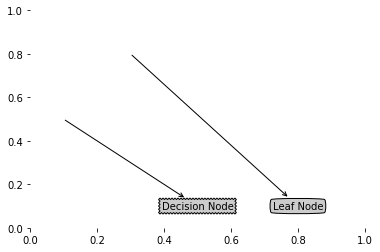

In [23]:
create_plot()

In [24]:
def get_num_leafs(my_tree):
    num_leafs = 0
    first_str = my_tree.keys()[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key].__name__)=="dict":
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs

In [25]:
def get_tree_depth(my_tree):
    max_depth = 0
    first_str = my_tree.keys()[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key].__name__=="dict"):
            this_depth = 1+get_tree_depth(second_dict[key])
        else:
            this_depth =1
        if this_depth>max_depth:
            max_depth = this_depth
    return max_depth

In [26]:
lenses = []
with open("lenses.txt") as fp:
    for line in fp:
        lenses.append(line.strip().split('\t'))

In [27]:
lenses_labels = ["age", "prescript", "astigmatic", "tearRate"]

In [28]:
lenses_tree = create_tree(lenses, lenses_labels)

In [29]:
lenses_tree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'young': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'pre': 'no lenses',
        'young': 'hard',
        'presbyopic': 'no lenses'}}}}}}}}